In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq fastbook

In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '81f90f5c8ab749349b9bb55342377315')

In [6]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [7]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [8]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

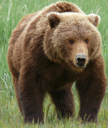

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#433) [Path('bears/teddy/ef37d193-197f-415c-8ff7-6fdb34baff54.jpg'),Path('bears/teddy/0422eb44-d673-4131-a665-e9c1f4ef8cbe.png'),Path('bears/teddy/fd791145-7d82-4d86-95b7-0d8b5292d17b.jpg'),Path('bears/teddy/4e4ece46-11f3-4586-8af1-da4605258499.jpg'),Path('bears/teddy/9dca91f4-54f6-4379-b876-a05112656d60.png'),Path('bears/teddy/01f3c41e-8f16-4b7a-b60b-631859d4aa8a.jpg'),Path('bears/teddy/68cc54b4-618c-46ed-81ec-b59e61fd399e.jpg'),Path('bears/teddy/8520e0ca-4ce0-4dfd-9a5d-3ce9bc4f95ca.png'),Path('bears/teddy/55f935ae-c40c-41a8-9f63-b14ee28dd187.jpg'),Path('bears/teddy/fb9b1631-fce3-4814-8df4-fd83e1bf8516.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#9) [Path('bears/teddy/644a7694-903e-4aab-ace5-7ac873505a2c.png'),Path('bears/teddy/d17bc8c2-78ac-4e4c-b643-8ac5eea4f6a7.jpg'),Path('bears/teddy/7318b039-2f29-489b-9773-aa3996699326.jpg'),Path('bears/teddy/e2cc731c-a13c-403f-9979-7e365a10c9d3.jpg'),Path('bears/teddy/e6c08112-d1bf-4c5e-a7a3-17e470a73f8c.jpg'),Path('bears/grizzly/5eea9169-112b-45b6-b192-477f155420c4.JPG'),Path('bears/grizzly/1b73ef90-2be0-44ff-9076-89108d9ef176.jpg'),Path('bears/black/9ddd015d-1944-4a4c-9ccc-bb83a3e00ba8.jpg'),Path('bears/black/83b7dcc6-b17e-439c-9fbd-08899aab2f97.jpg')]

In [15]:
failed.map(Path.unlink);

In [16]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/conda/lib/python3.10/site-packages/fastai/vision/utils.py
Type:      function

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = bears.dataloaders(path)

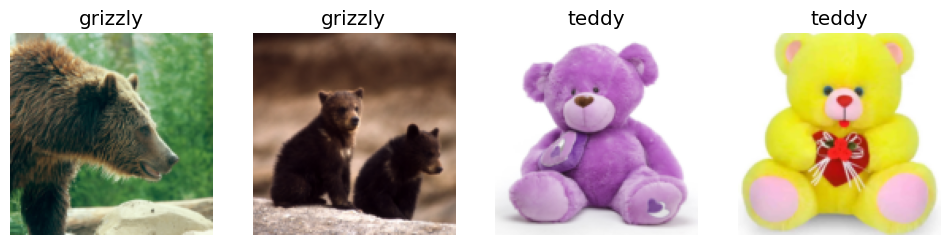

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

In [20]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.168919,0.108858,0.035714,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.208180,0.103862,0.023810,00:59
1,0.144235,0.128823,0.023810,00:59
2,0.119440,0.161057,0.023810,01:11
3,0.114446,0.153168,0.023810,01:31


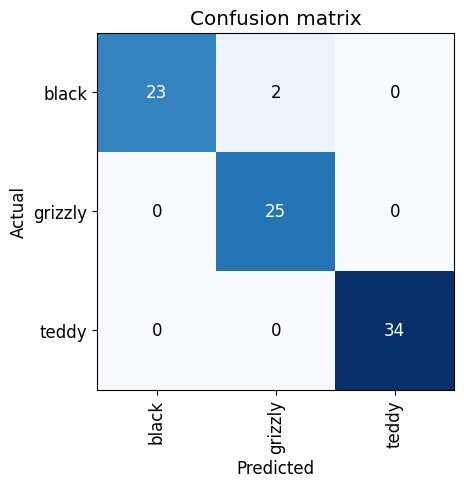

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

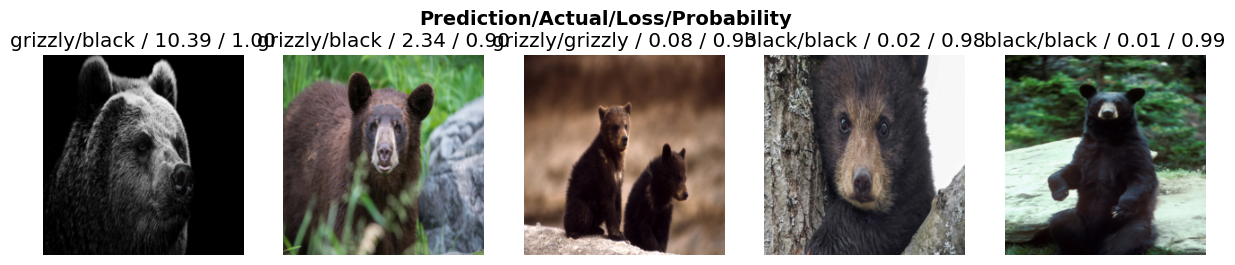

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.0834e-08, 1.0000e+00, 2.0883e-08]))

In [29]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [30]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [31]:
img = PILImage.create(btn_upload.data[-1])

In [32]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [33]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [35]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [37]:
btn_upload = widgets.FileUpload()

In [38]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [39]:
!pip install voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.4 MB/s eta 0:00:0000:0100:01


In [40]:
!jupyter serverextension enable --sys-prefix voila

Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.5.4 OK
